# 0005.0000e Modeling Strategy e

In [1]:
import pathlib
import sys
import joblib

import pandas as pd
import numpy as np
import missingno as msno

# import scipy.stats as stats
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from scipy.stats import poisson, nbinom


import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker
# import seaborn as sns

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload all modules
%autoreload 2
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))

from src.visualization.visualize import get_model_diagnosis
from src.visualization.visualize import extend_cols
from src.data.transform_long_to_wide import run_transform_ts_to_supervised
from src.data.transformed_to_all_stacked import transformed_to_all_stacked
from src.data.stacked_to_ts_featured import clean_df
from src.models.metrics import insert_rps

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

SAMPLE_DIR = PROJECT_DIR / 'data' / 'sample'
SAMP_STACKED_DIR = SAMPLE_DIR / '01-stacked-seasons'
SAMP_FEATURED_DIR = SAMPLE_DIR / '02-featured'
SAMP_TRANSFORMED_DIR = SAMPLE_DIR / '03-transformed'

# fn = '2007-2008__2017-2018.csv'
# EDA_FP = SAMPLE_DIR / '01-stacked-seasons' / 'germany' / 'bundesliga' / fn
# SAVED_IMAGES_DIR = PROJECT_DIR / 'notebooks' / 'saved-images'

fn = '2007-2008__2017-2018.csv'
SAMP_STACKED_FP = SAMP_STACKED_DIR / 'germany' / 'bundesliga' / fn
SAMP_FEATURED_FP = SAMP_FEATURED_DIR / 'germany' / 'bundesliga' / fn
SAMP_TRANSFORMED_FP = SAMP_TRANSFORMED_DIR / 'germany' / 'bundesliga' / fn
SAMP_MODEL_FP = SAMPLE_DIR / 'models' / 'optimized-model.joblib'
SAMP_CAL_FP = SAMPLE_DIR / 'models' / 'calibration-model.joblib'
SAVE_FP = SAMPLE_DIR / 'check-output' / 'test.csv'

In [2]:
SAMP_FEATURED_SUBDIRS  = str(SAMP_FEATURED_DIR) + '/*/'
SAMP_TRANSFORMED_SUBDIRS = str(SAMP_TRANSFORMED_DIR) + '/*/' 

In [3]:
!tree $SAMPLE_DIR -n

/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample
├── 01-stacked-seasons
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 02-featured
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 03-transformed
│   └── germany
│       └── bundesliga
│           └── 2007-2008__2017-2018.csv
├── 04-all-stacked
│   ├── 2007-2008__2009-2010.csv
│   ├── 2007-2008__2017-2018.csv
│   ├── germany
│   │   └── bundesliga
│   │       └── 2007-2008__2017-2018.csv
│   └── italy
│       └── serie-a
│           └── 2010-2011__2017-2018.csv
├── check-output
│   └── test.csv
└── models
    ├── calibration-model.joblib
    └── optimized-model.joblib

16 directories, 10 files


## 6. Select, Impute, Compress the Features

In [4]:
df_trans = pd.read_csv(SAMP_TRANSFORMED_FP,
                       parse_dates=['date']).sort_values(by=['date', 'h', 'a']).reset_index(drop=True)
# Sort the features

In [5]:
df_temp = df_trans.copy(deep=True)

from src.features.manipulation import (cut_historical_games,
                                       select_features,
                                       get_feature_name_stubs_from_base,
                                       get_base_features,
                                       get_df_from_base_features,
                                       get_features_df,
                                       get_non_features_df,
                                       get_target_df)

### Pre-Process

##### Select Features

There are so many features, it is a bit overwhelming, so we will focus on a few of them for the purposes of illustrating the concepts of the modeling strategy

#### Nomenclature

+ base_feature - ftGoals, htGoals, ...
+ feature_stub_set - h_h_ftGoals, a_a_ftGoals, h_a_ftGoals, a_h_ftGoals etc
+ feature_col_set - h_h_ftGoals-1, h_h_ftGoals-2, h_h_ftGoals-3, ..., a_h_ftGoals-16

In [6]:
base_features = get_base_features(df_temp)
base_features

['corners',
 'fouls',
 'ftGoals',
 'htGoals',
 'impliedDraw',
 'impliedLose',
 'impliedWin',
 'poissDraw',
 'poissLose',
 'poissWin',
 'redCards',
 'shots',
 'shotsOnTarget',
 'yellowCards']

In [7]:
selected_base_features = base_features
# selected_base_features = ['ftGoals', 'htGoals', 'shots']#  base_features
# selected_base_features = ['impliedWin', 'impliedDraw',  'impliedLose', 'poissWin', 'poissDraw', 'poissLose']#  base_features
# selected_base_features = ['redCards', 'yellowCards']#  base_features
# selected_base_features = ['corners', 'fouls']#  base_features
# selected_base_features = ['poissWin', 'poissDraw', 'poissLose',
#                           'impliedWin', 'impliedDraw', 'impliedLose',
#                          'ftGoals', 'htGoals', 'shots']#  base_features
df_select_features = get_df_from_base_features(df_trans, selected_base_features)
df_select_features.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_corners-0,h_h_corners-0,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_corners-5,a_h_corners-5,h_a_corners-5,h_h_corners-5,a_a_corners-6,a_h_corners-6,h_a_corners-6,h_h_corners-6,a_a_corners-7,a_h_corners-7,h_a_corners-7,h_h_corners-7,a_a_corners-8,a_h_corners-8,h_a_corners-8,h_h_corners-8,a_a_corners-9,a_h_corners-9,h_a_corners-9,h_h_corners-9,a_a_corners-10,a_h_corners-10,h_a_corners-10,h_h_corners-10,a_a_corners-11,a_h_corners-11,h_a_corners-11,h_h_corners-11,a_a_corners-12,a_h_corners-12,h_a_corners-12,h_h_corners-12,a_a_corners-13,a_h_corners-13,h_a_corners-13,h_h_corners-13,a_a_corners-14,a_h_corners-14,h_a_corners-14,h_h_corners-14,a_a_corners-15,a_h_corners-15,h_a_corners-15,h_h_corners-15,a_a_corners-16,a_h_corners-16,h_a_corners-16,h_h_corners-16,a_h_corners-17,h_a_corners-17,a_a_fouls-0,h_h_fouls-0,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_fouls-3,a_h_fouls-3,h_a_fouls-3,h_h_fouls-3,a_a_fouls-4,a_h_fouls-4,h_a_fouls-4,h_h_fouls-4,a_a_fouls-5,a_h_fouls-5,h_a_fouls-5,h_h_fouls-5,a_a_fouls-6,a_h_fouls-6,h_a_fouls-6,h_h_fouls-6,a_a_fouls-7,a_h_fouls-7,h_a_fouls-7,h_h_fouls-7,a_a_fouls-8,a_h_fouls-8,h_a_fouls-8,h_h_fouls-8,a_a_fouls-9,a_h_fouls-9,h_a_fouls-9,h_h_fouls-9,a_a_fouls-10,a_h_fouls-10,h_a_fouls-10,h_h_fouls-10,a_a_fouls-11,a_h_fouls-11,h_a_fouls-11,h_h_fouls-11,a_a_fouls-12,a_h_fouls-12,h_a_fouls-12,h_h_fouls-12,a_a_fouls-13,a_h_fouls-13,h_a_fouls-13,h_h_fouls-13,a_a_fouls-14,a_h_fouls-14,h_a_fouls-14,h_h_fouls-14,a_a_fouls-15,a_h_fouls-15,h_a_fouls-15,h_h_fouls-15,a_a_fouls-16,a_h_fouls-16,h_a_fouls-16,h_h_fouls-16,a_h_fouls-17,h_a_fouls-17,a_a_ftGoals-0,h_h_ftGoals-0,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_ftGoals-5,a_h_ftGoals-5,h_a_ftGoals-5,h_h_ftGoals-5,a_a_ftGoals-6,a_h_ftGoals-6,h_a_ftGoals-6,h_h_ftGoals-6,a_a_ftGoals-7,a_h_ftGoals-7,h_a_ftGoals-7,h_h_ftGoals-7,a_a_ftGoals-8,a_h_ftGoals-8,h_a_ftGoals-8,h_h_ftGoals-8,a_a_ftGoals-9,a_h_ftGoals-9,h_a_ftGoals-9,h_h_ftGoals-9,a_a_ftGoals-10,a_h_ftGoals-10,h_a_ftGoals-10,h_h_ftGoals-10,a_a_ftGoals-11,a_h_ftGoals-11,h_a_ftGoals-11,h_h_ftGoals-11,a_a_ftGoals-12,a_h_ftGoals-12,h_a_ftGoals-12,h_h_ftGoals-12,a_a_ftGoals-13,a_h_ftGoals-13,h_a_ftGoals-13,h_h_ftGoals-13,a_a_ftGoals-14,...,a_h_shots-3,a_h_shotsOnTarget-3,h_a_shots-3,h_a_shotsOnTarget-3,h_h_shots-3,h_h_shotsOnTarget-3,a_a_shots-4,a_a_shotsOnTarget-4,a_h_shots-4,a_h_shotsOnTarget-4,h_a_shots-4,h_a_shotsOnTarget-4,h_h_shots-4,h_h_shotsOnTarget-4,a_a_shots-5,a_a_shotsOnTarget-5,a_h_shots-5,a_h_shotsOnTarget-5,h_a_shots-5,h_a_shotsOnTarget-5,h_h_shots-5,h_h_shotsOnTarget-5,a_a_shots-6,a_a_shotsOnTarget-6,a_h_shots-6,a_h_shotsOnTarget-6,h_a_shots-6,h_a_shotsOnTarget-6,h_h_shots-6,h_h_shotsOnTarget-6,a_a_shots-7,a_a_shotsOnTarget-7,a_h_shots-7,a_h_shotsOnTarget-7,h_a_shots-7,h_a_shotsOnTarget-7,h_h_shots-7,h_h_shotsOnTarget-7,a_a_shots-8,a_a_shotsOnTarget-8,a_h_shots-8,a_h_shotsOnTarget-8,h_a_shots-8,h_a_shotsOnTarget-8,h

Select all features for the last n games defined in `n_back`

We can either drop all games where the teams have not played, or we can impute

This is quite a big notebook, so for the sake of brevity we will drop all games unless each team has played n previous games


In [8]:
n_back=4
df_cut = cut_historical_games(df_select_features, n_back=n_back, drop_all_nan_rows=True, how='any')
df_cut.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedDraw-3,a_h_impliedDraw-3,h_a_impliedDraw-3,h_h_impliedDraw-3,a_a_impliedDraw-4,a_h_impliedDraw-4,h_a_impliedDraw-4,h_h_impliedDraw-4,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedLose-3,a_h_impliedLose-3,h_a_impliedLose-3,h_h_impliedLose-3,a_a_impliedLose-4,a_h_impliedLose-4,h_a_impliedLose-4,h_h_impliedLose-4,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_impliedWin-3,a_h_impliedWin-3,h_a_impliedWin-3,h_h_impliedWin-3,a_a_impliedWin-4,a_h_impliedWin-4,h_a_impliedWin-4,h_h_impliedWin-4,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissDraw-3,a_h_poissDraw-3,h_a_poissDraw-3,h_h_poissDraw-3,a_a_poissDraw-4,a_h_poissDraw-4,h_a_poissDraw-4,h_h_poissDraw-4,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissLose-3,a_h_poissLose-3,h_a_poissLose-3,h_h_poissLose-3,a_a_poissLose-4,a_h_poissLose-4,h_a_poissLose-4,h_h_poissLose-4,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_poissWin-3,a_h_poissWin-3,h_a_poissWin-3,h_h_poissWin-3,a_a_poissWin-4,a_h_poissWin-4,h_a_poissWin-4,h_h_poissWin-4,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_fouls-3,a_h_fouls-3,h_a_fouls-3,h_h_fouls-3,a_a_fouls-4,a_h_fouls-4,h_a_fouls-4,h_h_fouls-4,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_htGoals-3,a_h_htGoals-3,h_a_htGoals-3,h_h_htGoals-3,a_a_htGoals-4,a_h_htGoals-4,h_a_htGoals-4,h_h_htGoals-4,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_redCards-3,a_h_redCards-3,h_a_redCards-3,h_h_redCards-3,a_a_redCards-4,a_h_redCards-4,h_a_redCards-4,h_h_redCards-4,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_shots-3,a_a_shotsOnTarget-3,a_h_shots-3,a_h_shotsOnTarget-3,h_a_shots-3,h_a_shotsOnTarget-3,h_h_shots-3,h_h_shotsOnTarget-3,a_a_shots-4,a_a_shotsOnTarget-4,a_h_

In [9]:
df_cut.shape

(2218, 295)

In [10]:
print(sum(df_cut.columns.duplicated()))

0


### Compress Feature Space

In [11]:
df_compress = df_cut.copy(deep=True)

def compress_all_features(df_orig, func='mean'):
    df = df_orig.copy(deep=True)
    feature_name_stubs = get_feature_name_stubs_from_base(df, selected_base_features)
    for feature_name_stub in feature_name_stubs:
        cols = [col for col in df.columns if '-' in col and feature_name_stub == col.rsplit('-',1)[0]]
        df[feature_name_stub + '-agg'] = df[cols].agg(func=func, axis=1)
        df.drop(columns = cols, inplace=True)
    return df

def drop_unused_features(df_orig):
    df = df_orig.copy(deep=True)
    redundant_features = [col for col in df.columns if 'agg' not in col and (col[0:2] =='h_' or col[0:2] == 'a_')]
    df.drop(columns=redundant_features, inplace=True)
    return df
    

# compressed_df = compress_all_features(df_compress, func='mean')
# compressed_df2 = drop_unused_features(compressed_df)
# compressed_df2.head()
compressed_df2 = df_compress

In [12]:
compressed_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Columns: 295 entries, nation to h_h_yellowCards-4
dtypes: datetime64[ns](1), float64(284), int64(4), object(6)
memory usage: 5.0+ MB


## Balance Features

In [13]:
compressed_df3 = compressed_df2.copy(deep=True)
compressed_df3 = compressed_df3.dropna().reset_index(drop=True)

In [14]:
# draws = compressed_df3[compressed_df3['result'] == 'draw']
# hwins = compressed_df3[compressed_df3['result'] == 'hwin'].sample(frac=0.55)
# awins = compressed_df3[compressed_df3['result'] == 'awin'].sample(frac=0.85)
# compressed_df4 = pd.concat([draws, awins, hwins], axis=0).sort_index().reset_index(drop=True)
compressed_df4 = compressed_df3.copy(deep=True)

In [15]:
# print(len(draws))
# print(len(awins))
# print(len(hwins))

In [16]:
compressed_df4.head()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedDraw-3,a_h_impliedDraw-3,h_a_impliedDraw-3,h_h_impliedDraw-3,a_a_impliedDraw-4,a_h_impliedDraw-4,h_a_impliedDraw-4,h_h_impliedDraw-4,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedLose-3,a_h_impliedLose-3,h_a_impliedLose-3,h_h_impliedLose-3,a_a_impliedLose-4,a_h_impliedLose-4,h_a_impliedLose-4,h_h_impliedLose-4,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_impliedWin-3,a_h_impliedWin-3,h_a_impliedWin-3,h_h_impliedWin-3,a_a_impliedWin-4,a_h_impliedWin-4,h_a_impliedWin-4,h_h_impliedWin-4,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissDraw-3,a_h_poissDraw-3,h_a_poissDraw-3,h_h_poissDraw-3,a_a_poissDraw-4,a_h_poissDraw-4,h_a_poissDraw-4,h_h_poissDraw-4,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissLose-3,a_h_poissLose-3,h_a_poissLose-3,h_h_poissLose-3,a_a_poissLose-4,a_h_poissLose-4,h_a_poissLose-4,h_h_poissLose-4,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_poissWin-3,a_h_poissWin-3,h_a_poissWin-3,h_h_poissWin-3,a_a_poissWin-4,a_h_poissWin-4,h_a_poissWin-4,h_h_poissWin-4,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_fouls-3,a_h_fouls-3,h_a_fouls-3,h_h_fouls-3,a_a_fouls-4,a_h_fouls-4,h_a_fouls-4,h_h_fouls-4,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_htGoals-3,a_h_htGoals-3,h_a_htGoals-3,h_h_htGoals-3,a_a_htGoals-4,a_h_htGoals-4,h_a_htGoals-4,h_h_htGoals-4,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_redCards-3,a_h_redCards-3,h_a_redCards-3,h_h_redCards-3,a_a_redCards-4,a_h_redCards-4,h_a_redCards-4,h_h_redCards-4,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_shots-3,a_a_shotsOnTarget-3,a_h_shots-3,a_h_shotsOnTarget-3,h_a_shots-3,h_a_shotsOnTarget-3,h_h_shots-3,h_h_shotsOnTarget-3,a_a_shots-4,a_a_shotsOnTarget-4,a_h_

In [17]:
compressed_df4.tail()

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedDraw-3,a_h_impliedDraw-3,h_a_impliedDraw-3,h_h_impliedDraw-3,a_a_impliedDraw-4,a_h_impliedDraw-4,h_a_impliedDraw-4,h_h_impliedDraw-4,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedLose-3,a_h_impliedLose-3,h_a_impliedLose-3,h_h_impliedLose-3,a_a_impliedLose-4,a_h_impliedLose-4,h_a_impliedLose-4,h_h_impliedLose-4,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_impliedWin-3,a_h_impliedWin-3,h_a_impliedWin-3,h_h_impliedWin-3,a_a_impliedWin-4,a_h_impliedWin-4,h_a_impliedWin-4,h_h_impliedWin-4,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissDraw-3,a_h_poissDraw-3,h_a_poissDraw-3,h_h_poissDraw-3,a_a_poissDraw-4,a_h_poissDraw-4,h_a_poissDraw-4,h_h_poissDraw-4,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissLose-3,a_h_poissLose-3,h_a_poissLose-3,h_h_poissLose-3,a_a_poissLose-4,a_h_poissLose-4,h_a_poissLose-4,h_h_poissLose-4,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_poissWin-3,a_h_poissWin-3,h_a_poissWin-3,h_h_poissWin-3,a_a_poissWin-4,a_h_poissWin-4,h_a_poissWin-4,h_h_poissWin-4,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_fouls-3,a_h_fouls-3,h_a_fouls-3,h_h_fouls-3,a_a_fouls-4,a_h_fouls-4,h_a_fouls-4,h_h_fouls-4,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_htGoals-3,a_h_htGoals-3,h_a_htGoals-3,h_h_htGoals-3,a_a_htGoals-4,a_h_htGoals-4,h_a_htGoals-4,h_h_htGoals-4,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_redCards-3,a_h_redCards-3,h_a_redCards-3,h_h_redCards-3,a_a_redCards-4,a_h_redCards-4,h_a_redCards-4,h_h_redCards-4,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_shots-3,a_a_shotsOnTarget-3,a_h_shots-3,a_h_shotsOnTarget-3,h_a_shots-3,h_a_shotsOnTarget-3,h_h_shots-3,h_h_shotsOnTarget-3,a_a_shots-4,a_a_shotsOnTarget-4,a_h_

## 7. Modeling

### Prepare for Data Splitting

Prior to modeling, we will split the DataFrame into 3 parts, all keeping the same row index
+ meta - all meta data
+ X - all features
+ y - target

In [18]:
df_model = compressed_df4.copy(deep=True)
# Reset index prior to any splitting
df_model = df_model.sort_values(by=['date'])
df_model = df_model.reset_index(drop=True)
meta = get_non_features_df(df_model)
meta.head(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight
0,germany,bundesliga,2007-2008,energie-cottbus,schalke,2007-11-02,1.0,0.0,hwin,6.0,17.0,0.0,0.259444,0.177905,0.562651,0.236677,0.096114,0.667208,0.0,15.0,3.0,3.0,1.66,1.65,1.73,1.66,0.275,0.275,0.45,3.6,3.55,3.93,3.47,6.0,19.0,0.0,0.259444,0.562651,0.177905,0.236677,0.667208,0.096114,0.0,16.0,5.0,2.0,5.25,4.75,5.81,5.1,0.562651,0.259444,0.177905,1,1,0,0,0.326797,0.611111
1,germany,bundesliga,2007-2008,hannover,dortmund,2007-11-03,2.0,1.0,hwin,4.0,19.0,0.0,0.276886,0.409310,0.313804,0.203593,0.579010,0.217379,0.0,12.0,5.0,2.0,3.00,2.70,3.25,2.90,0.275,0.275,0.45,3.4,3.20,3.40,3.23,13.0,13.0,0.0,0.276886,0.313804,0.409310,0.203593,0.217379,0.579010,0.0,21.0,5.0,2.0,2.30,2.40,2.43,2.3,0.313804,0.276886,0.409310,1,1,0,0,0.346405,0.611111


In [19]:
meta.tail(2)

,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight
2216,germany,bundesliga,2017-2018,sc-freiburg,augsburg,2018-05-12,2.0,0.0,hwin,4.0,17.0,0.0,0.278865,0.484796,0.236338,0.276275,0.287379,0.436345,0.0,5.0,2.0,2.0,4.00,3.9,4.3,3.85,0.275,0.275,0.45,3.39,3.4,3.60,3.40,5.0,13.0,0.0,0.278865,0.236338,0.484796,0.276275,0.436345,0.287379,0.0,12.0,3.0,1.0,1.95,2.00,2.11,2.00,0.236338,0.278865,0.484796,1,1,0,0,1.0,0.611111
2217,germany,bundesliga,2017-2018,wolfsburg,fc-koln,2018-05-12,4.0,1.0,hwin,10.0,17.0,1.0,0.238043,0.580592,0.181366,0.247620,0.544556,0.207823,0.0,6.0,1.0,3.0,5.25,5.0,5.5,4.98,0.275,0.275,0.45,4.00,4.1,4.36,4.11,5.0,12.0,1.0,0.238043,0.181366,0.580592,0.247620,0.207823,0.544556,0.0,16.0,8.0,2.0,1.64,1.65,1.70,1.64,0.181366,0.238043,0.580592,1,1,0,0,1.0,0.611111


In [20]:
meta.shape

(2218, 59)

In [21]:
X = get_features_df(df_model)
X.head(2)

,a_a_impliedDraw-0,h_h_impliedDraw-0,a_a_impliedDraw-1,a_h_impliedDraw-1,h_a_impliedDraw-1,h_h_impliedDraw-1,a_a_impliedDraw-2,a_h_impliedDraw-2,h_a_impliedDraw-2,h_h_impliedDraw-2,a_a_impliedDraw-3,a_h_impliedDraw-3,h_a_impliedDraw-3,h_h_impliedDraw-3,a_a_impliedDraw-4,a_h_impliedDraw-4,h_a_impliedDraw-4,h_h_impliedDraw-4,a_a_impliedLose-0,h_h_impliedLose-0,a_a_impliedLose-1,a_h_impliedLose-1,h_a_impliedLose-1,h_h_impliedLose-1,a_a_impliedLose-2,a_h_impliedLose-2,h_a_impliedLose-2,h_h_impliedLose-2,a_a_impliedLose-3,a_h_impliedLose-3,h_a_impliedLose-3,h_h_impliedLose-3,a_a_impliedLose-4,a_h_impliedLose-4,h_a_impliedLose-4,h_h_impliedLose-4,a_a_impliedWin-0,h_h_impliedWin-0,a_a_impliedWin-1,a_h_impliedWin-1,h_a_impliedWin-1,h_h_impliedWin-1,a_a_impliedWin-2,a_h_impliedWin-2,h_a_impliedWin-2,h_h_impliedWin-2,a_a_impliedWin-3,a_h_impliedWin-3,h_a_impliedWin-3,h_h_impliedWin-3,a_a_impliedWin-4,a_h_impliedWin-4,h_a_impliedWin-4,h_h_impliedWin-4,a_a_poissDraw-0,h_h_poissDraw-0,a_a_poissDraw-1,a_h_poissDraw-1,h_a_poissDraw-1,h_h_poissDraw-1,a_a_poissDraw-2,a_h_poissDraw-2,h_a_poissDraw-2,h_h_poissDraw-2,a_a_poissDraw-3,a_h_poissDraw-3,h_a_poissDraw-3,h_h_poissDraw-3,a_a_poissDraw-4,a_h_poissDraw-4,h_a_poissDraw-4,h_h_poissDraw-4,a_a_poissLose-0,h_h_poissLose-0,a_a_poissLose-1,a_h_poissLose-1,h_a_poissLose-1,h_h_poissLose-1,a_a_poissLose-2,a_h_poissLose-2,h_a_poissLose-2,h_h_poissLose-2,a_a_poissLose-3,a_h_poissLose-3,h_a_poissLose-3,h_h_poissLose-3,a_a_poissLose-4,a_h_poissLose-4,h_a_poissLose-4,h_h_poissLose-4,a_a_poissWin-0,h_h_poissWin-0,a_a_poissWin-1,a_h_poissWin-1,h_a_poissWin-1,h_h_poissWin-1,a_a_poissWin-2,a_h_poissWin-2,h_a_poissWin-2,h_h_poissWin-2,a_a_poissWin-3,a_h_poissWin-3,h_a_poissWin-3,h_h_poissWin-3,a_a_poissWin-4,a_h_poissWin-4,h_a_poissWin-4,h_h_poissWin-4,a_a_corners-1,a_h_corners-1,h_a_corners-1,h_h_corners-1,a_a_corners-2,a_h_corners-2,h_a_corners-2,h_h_corners-2,a_a_corners-3,a_h_corners-3,h_a_corners-3,h_h_corners-3,a_a_corners-4,a_h_corners-4,h_a_corners-4,h_h_corners-4,a_a_fouls-1,a_h_fouls-1,h_a_fouls-1,h_h_fouls-1,a_a_fouls-2,a_h_fouls-2,h_a_fouls-2,h_h_fouls-2,a_a_fouls-3,a_h_fouls-3,h_a_fouls-3,h_h_fouls-3,a_a_fouls-4,a_h_fouls-4,h_a_fouls-4,h_h_fouls-4,a_a_ftGoals-1,a_h_ftGoals-1,h_a_ftGoals-1,h_h_ftGoals-1,a_a_ftGoals-2,a_h_ftGoals-2,h_a_ftGoals-2,h_h_ftGoals-2,a_a_ftGoals-3,a_h_ftGoals-3,h_a_ftGoals-3,h_h_ftGoals-3,a_a_ftGoals-4,a_h_ftGoals-4,h_a_ftGoals-4,h_h_ftGoals-4,a_a_htGoals-1,a_h_htGoals-1,h_a_htGoals-1,h_h_htGoals-1,a_a_htGoals-2,a_h_htGoals-2,h_a_htGoals-2,h_h_htGoals-2,a_a_htGoals-3,a_h_htGoals-3,h_a_htGoals-3,h_h_htGoals-3,a_a_htGoals-4,a_h_htGoals-4,h_a_htGoals-4,h_h_htGoals-4,a_a_redCards-1,a_h_redCards-1,h_a_redCards-1,h_h_redCards-1,a_a_redCards-2,a_h_redCards-2,h_a_redCards-2,h_h_redCards-2,a_a_redCards-3,a_h_redCards-3,h_a_redCards-3,h_h_redCards-3,a_a_redCards-4,a_h_redCards-4,h_a_redCards-4,h_h_redCards-4,a_a_shots-1,a_a_shotsOnTarget-1,a_h_shots-1,a_h_shotsOnTarget-1,h_a_shots-1,h_a_shotsOnTarget-1,h_h_shots-1,h_h_shotsOnTarget-1,a_a_shots-2,a_a_shotsOnTarget-2,a_h_shots-2,a_h_shotsOnTarget-2,h_a_shots-2,h_a_shotsOnTarget-2,h_h_shots-2,h_h_shotsOnTarget-2,a_a_shots-3,a_a_shotsOnTarget-3,a_h_shots-3,a_h_shotsOnTarget-3,h_a_shots-3,h_a_shotsOnTarget-3,h_h_shots-3,h_h_shotsOnTarget-3,a_a_shots-4,a_a_shotsOnTarget-4,a_h_shots-4,a_h_shotsOnTarget-4,h_a_shots-4,h_a_shotsOnTarget-4,h_h_shots-4,h_h_shotsOnTarget-4,a_a_yellowCards-1,a_h_yellowCards-1,h_a_yellowCards-1,h_h_yellowCards-1,a_a_yellowCards-2,a_h_yellowCards-2,h_a_yellowCards-2,h_h_yellowCards-2,a_a_yellowCards-3,a_h_yellowCards-3,h_a_yellowCards-3,h_h_yellowCards-3,a_a_yellowCards-4,a_h_yellowCards-4,h_a_yellowCards-4,h_h_yellowCards-4
0,0.259444,0.259444,0.268657,0.277171,0.268440,0.277264,0.267746,0.217284,0.217284,0.288958,0.234783,0.246687,0.117318,0.284534,0.285429,0.223380,0.209095,0.284505,0.177905,0.562651,0.208955,0.303994,0.50786,0.251386,0.187422,0.110687,0.672029,0.375645,0.626087,0.156235,0.837989,0.354326,0.2728

In [22]:
X.shape

(2218, 236)

In [23]:
y = get_target_df(df_model, format='single_ordinal_result_column')
y.head(2)

0    1
1    1
Name: ordinal_result, dtype: int64

In [24]:
y.shape

(2218,)

### Split Into Train Test

In [25]:
test_seasons = ['2016-2017', '2017-2018']

train_full_index = meta[~meta['season'].isin(test_seasons)].index
held_out_test_index = meta[meta['season'].isin(test_seasons)].index

meta_train_full = meta.loc[train_full_index, :]
meta_held_out_test = meta.loc[held_out_test_index, :]

X_train_full = X.loc[train_full_index, :]
X_held_out_test = X.loc[held_out_test_index, :]

y_train_full = y.loc[train_full_index]
y_held_out_test = y.loc[held_out_test_index]

In [26]:
print(meta_train_full.shape)
print(X_train_full.shape)
print(y_train_full.shape)
print()
print(meta_held_out_test.shape)
print(X_held_out_test.shape)
print(y_held_out_test.shape)

(1821, 59)
(1821, 236)
(1821,)

(397, 59)
(397, 236)
(397,)


### Split Out Calibrate

In [27]:
cal_seasons = ['2014-2015', '2015-2016']

train_val_index = meta_train_full[~meta_train_full['season'].isin(cal_seasons)].index
cal_index = meta_train_full[meta_train_full['season'].isin(cal_seasons)].index

meta_train_val = meta_train_full.loc[train_val_index, :]
meta_cal = meta_train_full.loc[cal_index, :]

X_train_val = X_train_full.loc[train_val_index, :]
X_cal = X_train_full.loc[cal_index, :]

y_train_val = y_train_full.loc[train_val_index]
y_cal = y_train_full.loc[cal_index]

In [28]:
print(meta_train_val.shape)
print(X_train_val.shape)
print(y_train_val.shape)
print()
print(meta_cal.shape)
print(X_cal.shape)
print(y_cal.shape)

(1415, 59)
(1415, 236)
(1415,)

(406, 59)
(406, 236)
(406,)


In [29]:
from skoot.preprocessing import SelectiveMinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                              ExtraTreesClassifier, AdaBoostClassifier)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import NuSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
import mord as m

# clf = m.LogisticSE(max_iter=1000, alpha=1)
# clf = m.LogisticAT(max_iter=100, alpha=0.0) # Passable
# clf = m.LogisticIT(max_iter=100, alpha=0.0000) # Think profitable
# clf = GaussianNB(priors=[0.45, 0.275, 0.275])
# clf = MultinomialNB(class_prior=[0.45, 0.275, 0.275])
# clf = RandomForestClassifier(max_depth=25, class_weight='balanced')
# clf = MLPClassifier(learning_rate='adaptive', max_iter=1000, activation='relu', learning_rate_init=0.001) # - good 
# clf = MLPClassifier(hidden_layer_sizes=(100, ),learning_rate='constant', max_iter=5000,
#                     activation='relu', learning_rate_init=0.01) # good

# clf = RandomForestClassifier(class_weight='balanced', n_estimators=200,
#                              criterion='entropy', bootstrap=False, oob_score=False)

# clf = GradientBoostingClassifier() # Think Profitable
# clf = GradientBoostingClassifier(n_estimators=50,learning_rate=1.105, max_depth=10) # Think Profitable
# clf = AdaBoostClassifier()
# clf = ExtraTreesClassifier(n_estimators=20, criterion='entropy')
# clf = MLPClassifier()
# clf = QuadraticDiscriminantAnalysis(priors=[0.45, 0.275, 0.275])
# clf = QuadraticDiscriminantAnalysis()
clf = KNeighborsClassifier(n_neighbors=18, weights='distance', algorithm='brute',) # good !!
# clf = GaussianProcessClassifier()
# clf = DecisionTreeClassifier()
# clf = LogisticRegression(max_iter=1000)
# clf = XGBClassifier(objective="multi:softprob")
# clf = LinearDiscriminantAnalysis()
# clf = NuSVC(probability=True, class_weight='balanced')

n_splits=2
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
srs = SelectiveMinMaxScaler(trans_col_name='')

/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)
/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.2

Validation Fold: 1
Average Calibration Error:  0.463
Expected Calibration Error: 0.424
Maximum Calibration Error:  0.804
Number of Instances: 708


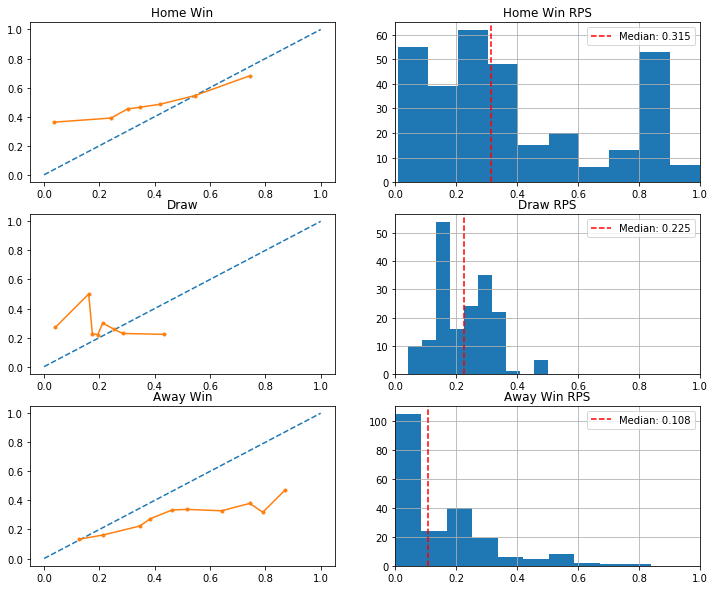


Validation Fold: 2
Average Calibration Error:  0.674
Expected Calibration Error: 0.674
Maximum Calibration Error:  0.964
Number of Instances: 707


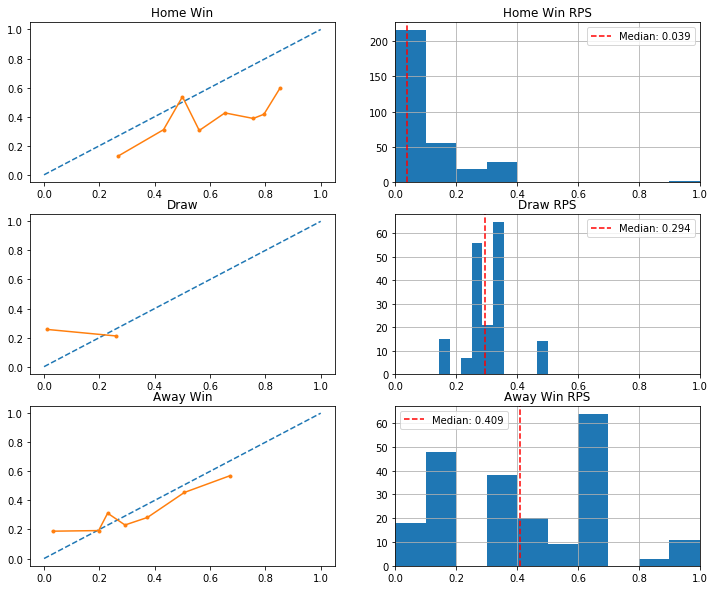

In [30]:
# validate_dfs = []

# rps_adj_scores = []
# bal_acc_scores = []

def run_fit_validate(X, y, X_cal, y_cal, meta_train_val, skf, clf, sig_clf):
    n = 0
    validate_dfs = []
  

    for fit_indices, validate_indices in skf.split(X, y):

        X_fit = X.iloc[fit_indices]
        y_fit = y.iloc[fit_indices]

        X_validate = X.iloc[validate_indices]
        y_validate = y.iloc[validate_indices]

        meta_fit = meta_train_val.iloc[fit_indices]
        meta_validate = meta_train_val.iloc[validate_indices]

        X_fit = srs.fit_transform(X_fit)
        clf.fit(X_fit, y_fit)

        X_validate = srs.transform(X_validate)
        validate_preds = clf.predict_proba(X_validate)

        # Probability calibration

        sig_clf.fit(X_cal, y_cal)
        sig_validate_preds = sig_clf.predict_proba(X_validate)

        #Build the DataFrame with the results for the validation data
        validate_preds_df = pd.DataFrame(sig_validate_preds, columns = clf.classes_, index = meta_validate.index)

        df_validate = pd.concat([meta_validate, X_validate, validate_preds_df], sort=False, axis=1)
        df_validate = insert_rps(df_validate)
        df_validate = insert_rps(df_validate,
                                 prob_cols=['implied_hwin', 'implied_draw', 'implied_awin'],
                                 return_col_prefix='bookie')
        df_validate = insert_rps(df_validate,
                                 prob_cols=['base_hwin_prob', 'base_draw_prob', 'base_awin_prob'],
                                 return_col_prefix='baseline')


        df_validate['pred_class'] = df_validate[[1,2, 3]].idxmax(axis=1)
        df_validate['pred_result'] = df_validate['pred_class'].map({1:'hwin', 2: 'draw', 3: 'awin'})
        #bal_acc_scores.append(balanced_accuracy_score(df_validate['result'], df_validate['pred_result'], adjusted=True))


        df_validate['n_fold'] = n
        n += 1

        validate_dfs.append(df_validate)
    for df in validate_dfs:
        print(f"Validation Fold: {df['n_fold'].unique()[0]+1}")
        get_model_diagnosis(df, add_baseline=True)
        plt.show();
        print()

sig_clf = CalibratedClassifierCV(clf, method="isotonic", cv="prefit")
run_fit_validate(X_train_val, y_train_val, X_cal, y_cal, meta_train_val, skf, clf, sig_clf)



In [31]:
joblib.dump(clf, SAMP_MODEL_FP)
joblib.dump(sig_clf, SAMP_CAL_FP)

['/media/david/5C14F53A14F517AA/code/ana_py37/projects/soccer-predictions/data/sample/models/calibration-model.joblib']

## 8. Simulate Gambling in Test Data

In [32]:
clf = joblib.load(SAMP_MODEL_FP)
clf

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=18, p=2,
                     weights='distance')

In [33]:
sig_clf = joblib.load(SAMP_CAL_FP)
sig_clf

CalibratedClassifierCV(base_estimator=KNeighborsClassifier(algorithm='brute',
                                                           leaf_size=30,
                                                           metric='minkowski',
                                                           metric_params=None,
                                                           n_jobs=None,
                                                           n_neighbors=18, p=2,
                                                           weights='distance'),
                       cv='prefit', method='isotonic')

In [34]:
meta_t = meta_held_out_test.copy(deep=True)
X_t = X_held_out_test.copy(deep=True)
y_t = y_held_out_test.copy(deep=True)

meta_t.reset_index(drop=True, inplace=True)
X_t.reset_index(drop=True, inplace=True)
y_t.reset_index(drop=True, inplace=True)

In [35]:
X_t = srs.transform(X_t)
test_preds = sig_clf.predict_proba(X_t)
test_preds_df = pd.DataFrame(test_preds, columns = clf.classes_)
# df_test = pd.concat([meta_t, X_t, test_preds_df], sort=False, axis=1)
df_test = pd.concat([meta_t, test_preds_df], sort=False, axis=1)

df_test['pred_class'] = df_test[[1,2, 3]].idxmax(axis=1)
df_test['pred_result'] = df_test['pred_class'].map({1:'hwin', 2: 'draw', 3: 'awin'})

df_test = insert_rps(df_test)
df_test = insert_rps(df_test,
                         prob_cols=['implied_hwin', 'implied_draw', 'implied_awin'],
                         return_col_prefix='bookie')
df_test = insert_rps(df_test,
                         prob_cols=['base_hwin_prob', 'base_draw_prob', 'base_awin_prob'],
                         return_col_prefix='baseline')



# # Do custom scoring
# baselineRPS_hwin = df_test[df_test['result'] == 'hwin']['baseline_rps'].median()
# baselineRPS_draw = df_test[df_test['result'] == 'draw']['baseline_rps'].median()
# baselineRPS_awin = df_test[df_test['result'] == 'awin']['baseline_rps'].median()

# modelMedRPS_hwin = df_test[df_test['result'] == 'hwin']['model_rps'].median()
# modelMedRPS_draw = df_test[df_test['result'] == 'draw']['model_rps'].median()
# modelMedRPS_awin = df_test[df_test['result'] == 'awin']['model_rps'].median()

# adjMedRPS_hwin = (modelMedRPS_hwin - baselineRPS_hwin) / baselineRPS_hwin  
# adjMedRPS_draw = (modelMedRPS_draw - baselineRPS_draw) / baselineRPS_draw 
# adjMedRPS_awin = (modelMedRPS_awin - baselineRPS_awin) / baselineRPS_awin
# adjRPS = np.mean([adjMedRPS_hwin, adjMedRPS_draw, adjMedRPS_awin])

# rps_adj_scores = [adjMedRPS_hwin, adjMedRPS_draw, adjMedRPS_awin]




# Calculate EVs
df_test['hwin_unit_EV'] = (df_test[1]* (df_test['hwinOddsMean']-1)) + ((1- df_test[1]) * -1)
df_test['draw_unit_EV'] = (df_test[2]* (df_test['drawOddsMean']-1)) + ((1- df_test[2]) * -1)
df_test['awin_unit_EV'] = (df_test[3]* (df_test['awinOddsMean']-1)) + ((1- df_test[3]) * -1)

# df_test['hwin_unit_EV'] = (df_test[1]* (df_test['hwinOddsBbMean']-1)) + ((1- df_test[1]) * -1)
# df_test['draw_unit_EV'] = (df_test[2]* (df_test['drawOddsBbMean']-1)) + ((1- df_test[2]) * -1)
# df_test['awin_unit_EV'] = (df_test[3]* (df_test['awinOddsBbMean']-1)) + ((1- df_test[3]) * -1)


# # Betting Strategy # 1
# # ## EV > Threshold ##
# EV_threshold = 0.1
# mask = (df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold).values
# df_test[['hwin_bet', 'draw_bet', 'awin_bet']] = pd.DataFrame(mask)

# Betting Strategy # 2
## EV > Threshold - Bet on Maximum EV for each Game ##
EV_threshold = 1.0
mask1 = (df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold).values
mask2 = df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values.max(axis=1,keepdims=1) == \
            df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values

mask = np.logical_and(mask1, mask2)
df_test[['hwin_bet', 'draw_bet', 'awin_bet']] = pd.DataFrame(mask)


# # Betting Strategy # 3
# ## EV > Threshold - Bet on Maximum EV for each Game, but no home wins##
# EV_threshold = 0.1
# mask1 = (df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold).values
# mask2 = df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values.max(axis=1,keepdims=1) == \
#             df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values

# mask = np.logical_and(mask1, mask2)
# mask[:,0] = 0
# df_test[['hwin_bet', 'draw_bet', 'awin_bet']] = pd.DataFrame(mask)


# # Betting Strategy # 4
# ## EV > Threshold - Bet on Maximum EV for each Game, only bet on draws##
# EV_threshold = 0.1
# mask1 = (df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold).values
# mask2 = df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values.max(axis=1,keepdims=1) == \
#             df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']].values

# mask = np.logical_and(mask1, mask2)
# mask[:,0] = 0
# mask[:,1] = 0
# df_test[['hwin_bet', 'draw_bet', 'awin_bet']] = pd.DataFrame(mask)




# # Betting Strategy # 5
# # ## EV > EV_Threshold - Odds < odds_threshold ##
# EV_threshold = 0.1
# odds_threshold = 6.0

# mask1 = (df_test[['hwin_unit_EV', 'draw_unit_EV', 'awin_unit_EV']] >= EV_threshold).values
# mask2 = (df_test[['hwinOddsMean', 'drawOddsMean', 'awinOddsMean']] <= odds_threshold).values

# mask = np.logical_and(mask1, mask2)

# df_test['hwin_bet'] = 0 ; df_test['draw_bet'] = 0 ; df_test['awin_bet'] = 0
# df_test[['hwin_bet', 'draw_bet', 'awin_bet']] = mask


# Do betting
conditions = [(df_test['hwin_bet'] == 1) & (df_test['ordinal_result_1'] == 1), # Place Bet - bet wins
              (df_test['hwin_bet'] == 1) & (df_test['ordinal_result_1'] == 0)] # Place bet - bet loses
choices = [(df_test['hwinOddsMax']-1), -1]
# choices = [(df_test['hwinOddsBbMean']-1), -1]
df_test['hwin_rets'] = np.select(conditions, choices, default=0) # default - no bet placed

conditions = [(df_test['draw_bet'] == 1) & (df_test['ordinal_result_2'] == 1), # Place Bet - bet wins
              (df_test['draw_bet'] == 1) & (df_test['ordinal_result_2'] == 0)] # Place bet - bet loses
choices = [(df_test['drawOddsMax']-1), -1]
# choices = [(df_test['drawOddsBbMean']-1), -1]
df_test['draw_rets'] = np.select(conditions, choices, default=0)

conditions = [(df_test['awin_bet'] == 1) & (df_test['ordinal_result_3'] == 1), # Place Bet - bet wins
              (df_test['awin_bet'] == 1) & (df_test['ordinal_result_3'] == 0)] # Place bet - bet loses
choices = [(df_test['awinOddsMax']-1), -1]
# choices = [(df_test['awinOddsBbMean']-1), -1]
df_test['awin_rets'] = np.select(conditions, choices, default=0)

def get_placed_bet(row):
    if row[0]:
        return 'hwin_bet'
    elif row[1]:
        return 'draw_bet'
    elif row[2]:
        return 'awin_bet'
    else:
        return 'no_bet'
    
df_test['placed_bet'] = df_test[['hwin_bet', 'draw_bet', 'awin_bet']].apply(get_placed_bet, axis=1)


df_test['game_ret'] = df_test[['hwin_rets', 'draw_rets', 'awin_rets']].sum(axis=1)

df_test.to_csv(SAVE_FP, index=False)

df_test.head(15)

/home/david/anaconda3/envs/ana_py37/lib/python3.7/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


,nation,league,season,h,a,date,h_ftGoals,a_ftGoals,result,a_corners,a_fouls,a_htGoals,a_impliedDraw,a_impliedLose,a_impliedWin,a_poissDraw,a_poissLose,a_poissWin,a_redCards,a_shots,a_shotsOnTarget,a_yellowCards,awinOdds,awinOddsBwa,awinOddsMax,awinOddsMean,base_awin_prob,base_draw_prob,base_hwin_prob,drawOdds,drawOddsBwa,drawOddsMax,drawOddsMean,h_corners,h_fouls,h_htGoals,h_impliedDraw,h_impliedLose,h_impliedWin,h_poissDraw,h_poissLose,h_poissWin,h_redCards,h_shots,h_shotsOnTarget,h_yellowCards,hwinOdds,hwinOddsBwa,hwinOddsMax,hwinOddsMean,implied_awin,implied_draw,implied_hwin,ordinal_result,ordinal_result_1,ordinal_result_2,ordinal_result_3,seasonPercentile,weight,1,2,3,pred_class,pred_result,model_rps,bookie_rps,baseline_rps,hwin_unit_EV,draw_unit_EV,awin_unit_EV,hwin_bet,draw_bet,awin_bet,hwin_rets,draw_rets,awin_rets,placed_bet,game_ret
0,germany,bundesliga,2016-2017,sc-freiburg,rb-leipzig,2016-11-25,1.0,4.0,awin,5.0,16.0,3.0,0.263607,0.249733,0.486660,0.206563,0.169220,0.624207,0.0,16.0,7.0,3.0,1.95,1.95,2.06,1.96,0.275,0.275,0.45,3.60,3.60,3.80,3.60,4.0,10.0,1.0,0.263607,0.486660,0.249733,0.206563,0.624207,0.169220,0.0,9.0,3.0,2.0,3.80,3.90,4.05,3.85,0.486660,0.263607,0.249733,3,0,0,1,0.326797,1.000000,0.428571,0.000000,0.571429,3,awin,0.183673,0.162943,0.364063,0.650000,-1.000000,0.120000,False,False,False,0.00,0.0,0.00,no_bet,0.00
1,germany,bundesliga,2016-2017,dortmund,borussia-monchengladbach,2016-12-03,4.0,1.0,hwin,3.0,10.0,1.0,0.213115,0.639344,0.147541,0.148762,0.765202,0.085964,0.0,3.0,1.0,1.0,6.50,6.75,7.00,6.39,0.275,0.275,0.45,4.50,4.40,4.85,4.48,9.0,10.0,2.0,0.213115,0.147541,0.639344,0.148762,0.085964,0.765202,0.0,15.0,7.0,1.0,1.50,1.48,1.55,1.50,0.147541,0.213115,0.639344,1,1,0,0,0.375817,0.611111,1.000000,0.000000,0.000000,1,hwin,0.000000,0.075920,0.189062,0.500000,-1.000000,-1.000000,False,False,False,0.00,0.0,0.00,no_bet,0.00
2,germany,bundesliga,2016-2017,hoffenheim,fc-koln,2016-12-03,4.0,0.0,hwin,4.0,11.0,0.0,0.280624,0.454343,0.265033,0.292698,0.305684,0.401618,0.0,10.0,1.0,1.0,3.60,3.50,3.65,3.48,0.275,0.275,0.45,3.40,3.50,3.65,3.47,3.0,14.0,2.0,0.280624,0.265033,0.454343,0.292698,0.401618,0.305684,0.0,10.0,6.0,1.0,2.10,2.10,2.21,2.12,0.265033,0.280624,0.454343,1,1,0,0,0.375817,0.611111,0.802817,0.000000,0.197183,1,hwin,0.038881,0.183992,0.189062,0.701972,-1.000000,-0.313803,False,False,False,0.00,0.0,0.00,no_bet,0.00
3,germany,bundesliga,2016-2017,leverkusen,sc-freiburg,2016-12-03,1.0,1.0,draw,3.0,10.0,1.0,0.227273,0.636364,0.136364,0.190332,0.583064,0.226558,0.0,10.0,2.0,1.0,7.00,6.50,7.00,6.47,0.275,0.275,0.45,4.20,4.33,4.74,4.36,4.0,10.0,0.0,0.227273,0.136364,0.636364,0.190332,0.226558,0.583064,0.0,13.0,6.0,0.0,1.50,1.50,1.56,1.50,0.136364,0.227273,0.636364,2,0,1,0,0.375817,1.000000,1.000000,0.000000,0.000000,1,hwin,0.500000,0.211777,0.139062,0.500000,-1.000000,-1.000000,False,False,False,0.00,0.0,0.00,no_bet,0.00
4,germany,bundesliga,2016-2017,rb-leipzig,schalke,2016-12-03,2.0,1.0,hwin,5.0,20.0,1.0,0.287770,0.474820,0.237410,0.238713,0.581386,0.179900,0.0,11.0,5.0,5.0,4.00,3.75,4.10,3.82,0.275,0.275,0.45,3.30,3.50,3.65,3.44,8.0,16.0,1.0,0.287770,0.237410,0.474820,0.238713,0.179900,0.581386,0.0,14.0,5.0,1.0,2.00,2.00,2.09,2.01,0.237410,0.287770,0.474820,1,1,0,0,0.375817,0.611111,1.000000,0.000000,0.000000,1,hwin,0.000000,0.166089,0.189062,1.010000,-1.000000,-1.000000,True,False,False,1.09,0.0,0.00,hwin_bet,1.09
5,germany,bundesliga,2016-2017,sv-werder-bremen,ingolstadt,2016-12-03,2.0,1.0,hwin,4.0,16.0,0.0,0.289190,0.381731,0.329079,0.225808,0.472130,0.302058,0.0,15.0,5.0,3.0,2.90,2.95,3.25,2.96,0.275,0.275,0.45,3.30,3.30,3.50,3.36,3.0,18.0,1.0,0.289190,0.329079,0.381731,0.225808,0.302058,0.472130,0.0,14.0,5.0,0.0,2.50,2.45,2.53,2.41,0.329079,0.289190,0.381731,1,1,0,0,0.375817,0.611111,0.428571,0.000000,0.571429,3,awin,0.326531,0.245275,0.189062,0.032857,-1.000000,0.691429,False,False,False,0.00,0.0,0.00,no_bet,0.00
6,germany,bundesliga,2016-2017,wolfsburg,hertha-berlin,2016-12-03,2.0,3.0,awin,2

Average Calibration Error:  0.631
Expected Calibration Error: 0.670
Maximum Calibration Error:  1.000
Number of Instances: 397


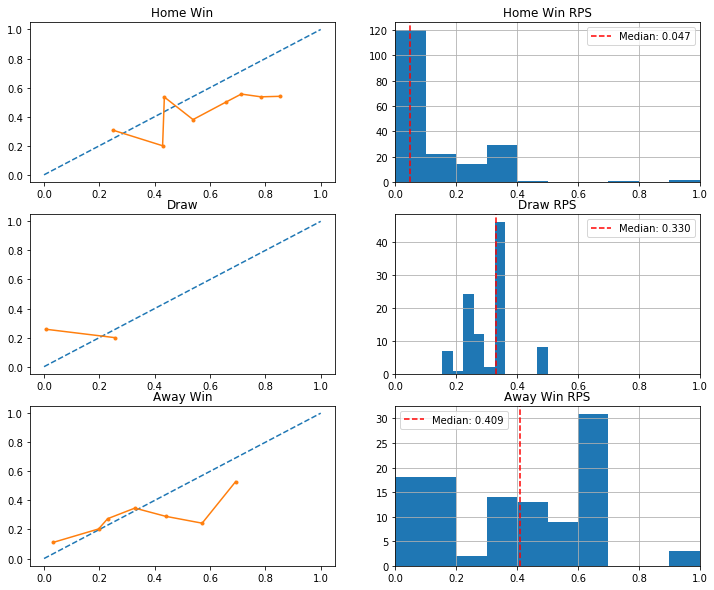

In [36]:
get_model_diagnosis(df_test, add_baseline=True)
plt.show();

In [37]:
print(df_test['hwin_rets'].sum())
print(df_test['draw_rets'].sum())
print(df_test['awin_rets'].sum())
print()
print(f"Total profit/loss: {df_test[['hwin_rets', 'draw_rets', 'awin_rets']].sum(axis=1).sum()}")

22.389999999999997
0.0
30.869999999999997

Total profit/loss: 53.26


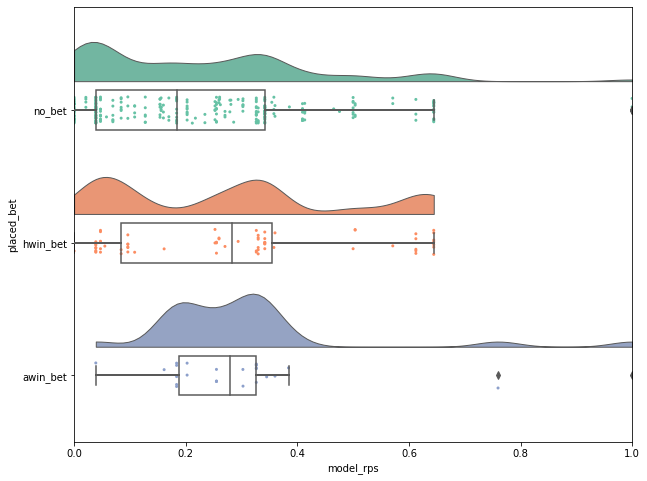

pred hwin: 22.389999999999997 on 70 bets
pred draw: 0.0 on 0 bets
pred awin: 30.869999999999997 on 26 bets
96 bets returning 53.26 over 397 games


In [38]:
import ptitprince as pt
fig, ax = plt.subplots(figsize=(10,8))
ax = pt.RainCloud(x='placed_bet', y='model_rps', data=df_test, width_viol=0.8, width_box=0.3,
                  orient='h', pointplot=False)
ax.set_xlim(0.0, 1.0)
#plt.axvline(x=0.1, c='r')
plt.show();
print(f'pred hwin: {df_test["hwin_rets"].sum()} on {df_test["hwin_bet"].sum()} bets')
print(f'pred draw: {df_test["draw_rets"].sum()} on {df_test["draw_bet"].sum()} bets')
print(f'pred awin: {df_test["awin_rets"].sum()} on {df_test["awin_bet"].sum()} bets')
print(f'{df_test[["hwin_bet" , "draw_bet", "awin_bet"]].sum().sum()} bets returning {df_test["game_ret"].sum()} over {len(df_test)} games')

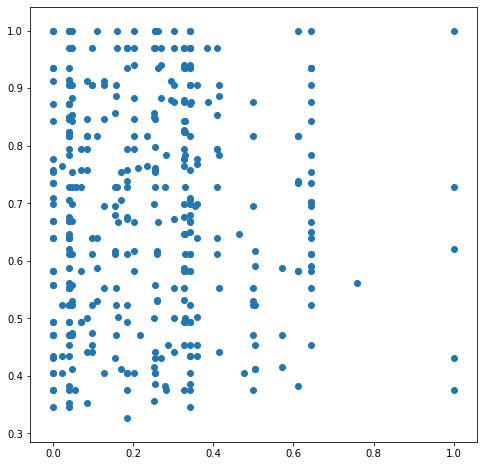

In [39]:
df_play = df_test.copy(deep=True)
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(df_test['model_rps'], df_test['seasonPercentile'] )
plt.show();

In [40]:
stop

NameError: name 'stop' is not defined

In [ ]:
hwin_rpss = df_test[df_test['result'] == 'hwin']['model_rps']
draw_rpss = df_test[df_test['result'] == 'draw']['model_rps']
awin_rpss = df_test[df_test['result'] == 'awin']['model_rps']

bins=10
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7,7),sharex=True)

ax1.hist(hwin_rpss, bins=bins)
ax1.set_xlim(0,1.0)
ax1.axvline(baselineRPS_hwin, color='r')
ax1.axvline(hwin_rpss.median(), color='r', linestyle='dashed')
ax1.set_title('Home Win RPS')
ax1.grid()

ax2.hist(draw_rpss, bins=bins)
ax2.axvline(baselineRPS_draw, color='r')
ax2.axvline(draw_rpss.median(), color='r', linestyle='dashed')
ax2.set_title('Draw RPS')
ax2.grid()

ax3.hist(awin_rpss, bins=bins)
ax3.axvline(baselineRPS_awin, color='r')
ax3.axvline(awin_rpss.median(), color='r', linestyle='dashed')
ax3.set_title('Away Win RPS')
ax3.grid()

plt.suptitle('Model RPS')
plt.show();

In [ ]:
# reliability diagram
bins=10
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7,7),sharex=True)
fop1, mpv1 = calibration_curve(df_test['ordinal_result_1'], df_test[1], n_bins=10)
# plot perfectly calibrated
ax1.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
ax1.plot(mpv1, fop1, marker='.')
ax1.set_title('hwin')

fop2, mpv2 = calibration_curve(df_test['ordinal_result_2'], df_test[2], n_bins=10)
# plot perfectly calibrated
ax2.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
ax2.plot(mpv2, fop2, marker='.')
ax2.set_title('draw')

fop3, mpv3 = calibration_curve(df_test['ordinal_result_3'], df_test[3], n_bins=10)
# plot perfectly calibrated
ax3.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
ax3.plot(mpv3, fop3, marker='.')
ax3.set_title('awin')

plt.show();

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
calibrator = CalibratedClassifierCV(clf, cv='prefit', method='isotonic')
calibrator.fit(X_validate, y_validate)
# evaluate the model
yhat = calibrator.predict_proba(X_t)
yhat

In [ ]:
# reliability diagram
bins=10
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7,7),sharex=True)
fop1, mpv1 = calibration_curve(df_test['ordinal_result_1'], yhat[:, 0], n_bins=10)
# plot perfectly calibrated
ax1.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
ax1.plot(mpv1, fop1, marker='.')
ax1.set_title('hwin')

fop2, mpv2 = calibration_curve(df_test['ordinal_result_2'], yhat[:,1], n_bins=10)
# plot perfectly calibrated
ax2.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
ax2.plot(mpv2, fop2, marker='.')
ax2.set_title('draw')

fop3, mpv3 = calibration_curve(df_test['ordinal_result_3'], yhat[:,2], n_bins=10)
# plot perfectly calibrated
ax3.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
ax3.plot(mpv3, fop3, marker='.')
ax3.set_title('awin')

plt.show();

In [ ]:
print(f"n_bets: {df_test[['hwin_bet', 'draw_bet', 'awin_bet']].sum(axis=1).sum()}")
print(f"n_games: {len(df_test)}")
print(f"Total Return: {df_test['game_ret'].sum()}")     
print(f"Unit Ret per Game: {df_test['game_ret'].sum()/ len(df_test)}")
print(f"Unit Ret per Bet: {df_test['game_ret'].sum()/ df_test[['hwin_bet', 'draw_bet', 'awin_bet']].sum(axis=1).sum()}")

In [ ]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

df_play2 = df_play.copy(deep=True)
df_play2 = df_play2[df_play2['placed_bet'] != 'no_bet']
df_play2['placed_bet'] = df_play2['placed_bet'].str[0:4]

cm = confusion_matrix(y_target=df_play2['result'], 
                      y_predicted=df_play2['placed_bet'], 
                      binary=False)
cm

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [ ]:
### Fit Model to all Training Data using Best Parameters - Not working !

In [ ]:
def run_fit(X, y, X_cal, y_cal, meta, clf):
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    X_cal.reset_index(drop=True, inplace=True)
    y_cal.reset_index(drop=True, inplace=True)
    meta.reset_index(drop=True, inplace=True)
  
    X_fit = srs.fit_transform(X)
    clf.fit(X_fit, y)

    validate_preds = clf.predict_proba(X_fit)

#     # Probability calibration
#     sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
#     sig_clf.fit(X_cal, y_cal)
#     sig_validate_preds = sig_clf.predict_proba(X_fit)

    #Build the DataFrame with the results for the validation data
    validate_preds_df = pd.DataFrame(validate_preds, columns = clf.classes_, index = meta.index)

    df = pd.concat([meta, X_fit, validate_preds_df], sort=False, axis=1)
    df = insert_rps(df)
    df = insert_rps(df, prob_cols=['implied_hwin', 'implied_draw', 'implied_awin'],
                    return_col_prefix='bookie')
    df = insert_rps(df, prob_cols=['base_hwin_prob', 'base_draw_prob', 'base_awin_prob'],
                    return_col_prefix='baseline')


    df['pred_class'] = df[[1,2, 3]].idxmax(axis=1)
    df['pred_result'] = df['pred_class'].map({1:'hwin', 2: 'draw', 3: 'awin'})
    bal_acc_scores.append(balanced_accuracy_score(df['result'], df['pred_result'], adjusted=True))

    get_model_diagnosis(df, add_baseline=True)
    plt.show();

clf = RandomForestClassifier(max_depth=25, class_weight='balanced')
srs = SelectiveMinMaxScaler(trans_col_name='')

run_fit(X_train_val, y_train_val, X_cal, y_cal, meta_train_val, clf)



In [ ]:
df.head()